# 测试控制台

你知道吗？阳见惠凪太可爱了

In [ ]:
from backend.pipeline import quick_build_pod

res = quick_build_pod(
    nc_path="data/cylinder2d.nc",
    r=128,
    center=True,
    var_keys=("u", "v"),
    verbose=True,   # 打印所有中间过程
    plot=True,      # 画出奇异值谱+累计能量图
)

print("实际使用的模态数 r_used =", res["r_used"])
print("前10阶累计能量:", res["cum_energy"][:10])


In [ ]:
from backend.pipeline import quick_test_linear_baseline

res = quick_test_linear_baseline(
    nc_path="data/cylinder2d.nc",
    pod_dir="artifacts/pod_r128",
    r=128,
    center=True,
    var_keys=("u", "v"),
    frame_idx=0,
    mask_rate=0.02,
    noise_sigma=0.01,
    max_modes=64,      # 前 64 个模态
    modes_per_fig=16,  # 每 16 个为一组：q1-16, q17-32, q33-48, q49-64
    channel=0,
    verbose=True,
)

print("POD 自身截断误差 NMSE =", res["nmse_pod"])
print("线性基线重建 NMSE      =", res["nmse_linear"])


[quick_test_mlp] Found existing POD in artifacts/pod_r128, skip rebuilding.
[quick_test_mlp] Loading POD artifacts...
  - meta: T=1501, H=80, W=640, C=2, r_used=128
[quick_test_mlp] Loading full raw data from data/cylinder2d.nc ...
  - X_thwc shape = (1501, 80, 640, 2), flattened = [1501, 102400]
[quick_test_mlp] Generating fixed spatial mask...
  - mask_rate target = 0.0200, actual ≈ 0.0200 over H×W×C
  - total observed entries (with 2 channels) = 2048
[quick_test_mlp] POD truncation self-reconstruction on target frame...
  -> 使用 r_eff = 128 个模态，对该帧 snapshot 投影后叠加重构
  -> NMSE(POD truncation, r_eff=128) = 2.6630e-05
[quick_test_mlp] Linear least-squares baseline on target frame...
  -> NMSE(Linear baseline, r_eff=128) = 9.6273e-02
[quick_test_mlp] Training MLP on full time series observations...
  -> MLP noise_sigma=0.01, batch_size=64, num_epochs=50, lr=0.001
[train_mlp] Dataset size: N=1501, train=1351, val=150
[train_mlp] Obs dim M=2048, coeff dim r=128, device=cuda
[train_mlp] Epoc

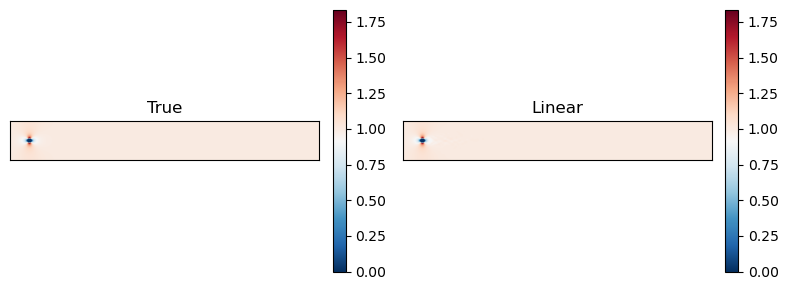

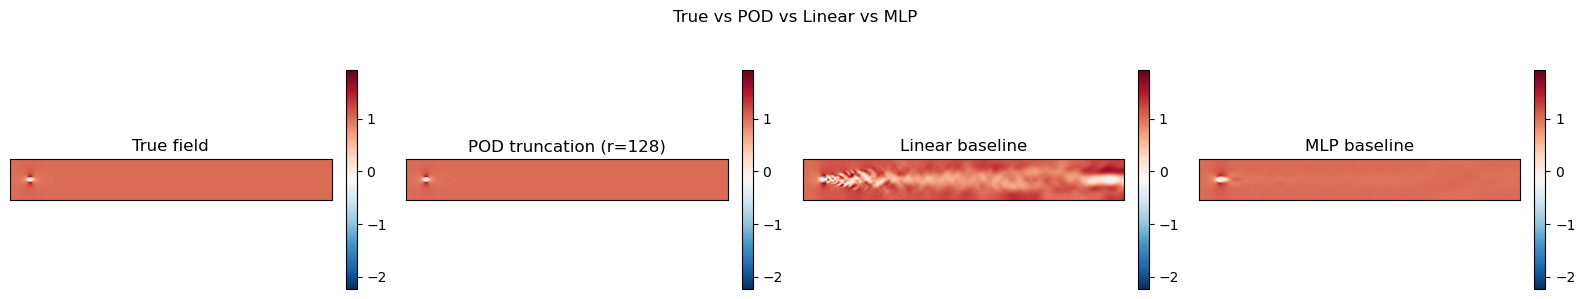

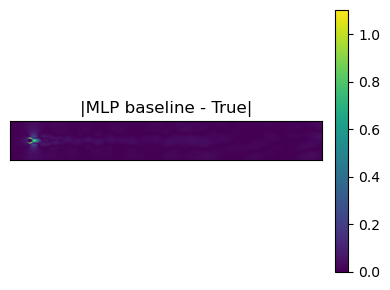

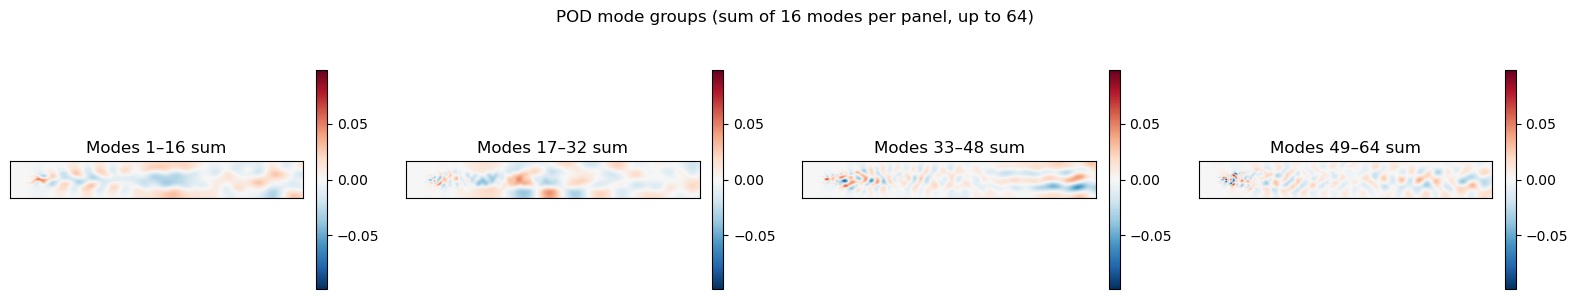

In [1]:
from backend.pipeline import quick_test_mlp_baseline

res = quick_test_mlp_baseline(
    nc_path="data/cylinder2d.nc",
    pod_dir="artifacts/pod_r128",
    r=128,
    center=True,
    var_keys=("u", "v"),
    frame_idx=0,
    mask_rate=0.02,
    noise_sigma=0.01,
    mlp_noise_sigma=0.01,
    batch_size=64,
    num_epochs=50,
    lr=1e-3,
    max_modes=64,
    modes_per_fig=16,
    channel=0,
    verbose=True,
)

print("NMSE(POD truncation) =", res["nmse_pod"])
print("NMSE(Linear baseline) =", res["nmse_linear"])
print("NMSE(MLP baseline)   =", res["nmse_mlp"])


=== [eval-linear] Start linear baseline experiment ===
[eval] Found existing POD in artifacts/pod_r128, skip rebuilding.
  - meta: T=1501, H=80, W=640, C=2, r_used=128, r_eff=128
[eval] Loading full raw data from data/cylinder2d.nc ...
  -> X_thwc shape = (1501, 80, 640, 2), flatten = [1501, 102400], r_eff=128
  -> Projected all snapshots to POD space: A_true shape = (1501, 128)

[eval-linear] mask_rate = 0.0100
  -> total observed entries (with 2 channels) = 1024
  [eval-linear] noise_sigma = 0.0000e+00
    -> NMSE(mean±std) = 6.9381e-01 ± 1.0554e-02, NMAE = 5.7261e-01, PSNR = 11.54 dB
  [eval-linear] noise_sigma = 1.0000e-02
    -> NMSE(mean±std) = 6.9405e-01 ± 1.0914e-02, NMAE = 5.7265e-01, PSNR = 11.54 dB
  [eval-linear] noise_sigma = 2.0000e-02
    -> NMSE(mean±std) = 6.9432e-01 ± 1.1807e-02, NMAE = 5.7277e-01, PSNR = 11.54 dB

[eval-linear] mask_rate = 0.0200
  -> total observed entries (with 2 channels) = 2048
  [eval-linear] noise_sigma = 0.0000e+00
    -> NMSE(mean±std) = 9.26

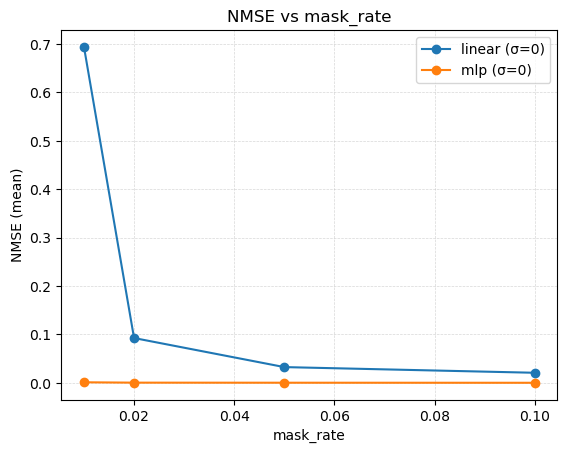

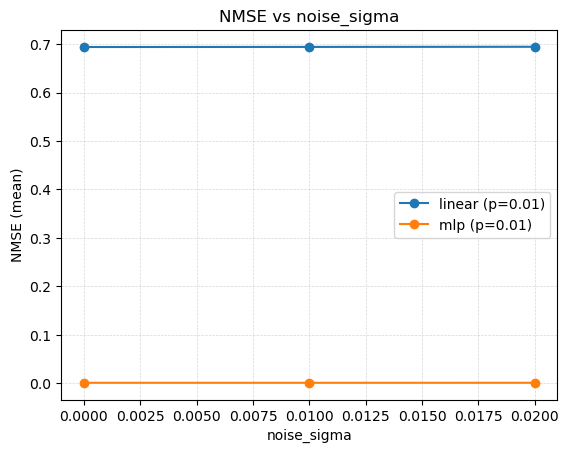

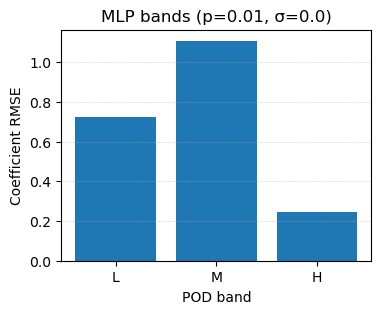

In [1]:
from pathlib import Path
from backend.config.schemas import DataConfig, PodConfig, EvalConfig, TrainConfig
from backend.eval.reconstruction import run_linear_baseline_experiment, run_mlp_experiment
from backend.eval.reports import results_to_dataframe
from backend.viz.curves import plot_nmse_vs_mask_rate, plot_nmse_vs_noise
from backend.viz.multiscale_plots import plot_multiscale_bar

# 1. 配置
data_cfg = DataConfig(
    nc_path=Path("data/cylinder2d.nc"),
    var_keys=("u", "v"),
)

pod_cfg = PodConfig(
    r=128,
    center=True,
    save_dir=Path("artifacts/pod_r128"),
)

eval_cfg = EvalConfig(
    mask_rates=[0.01, 0.02, 0.05, 0.1],
    noise_sigmas=[0.0, 0.01, 0.02],
    pod_bands={
        "L": (0, 16),
        "M": (16, 64),
        "H": (64, 128),
    },
    save_dir=Path("artifacts/eval"),
)

train_cfg = TrainConfig(
    mask_rate=0.02,                 # 这里只用于记录，真正训练时我们按 eval_cfg.mask_rates 循环
    noise_sigma=0.01,               # 训练噪声
    hidden_dims=(256, 256),
    lr=1e-3,
    batch_size=64,
    max_epochs=50,
    device="cuda",
    save_dir=Path("artifacts/nn"),
)

# 2. 线性基线 sweep
res_lin = run_linear_baseline_experiment(
    data_cfg,
    pod_cfg,
    eval_cfg,
    verbose=True,
)

df_lin = results_to_dataframe(res_lin)
print(df_lin.head())

# 3. MLP sweep
res_mlp = run_mlp_experiment(
    data_cfg,
    pod_cfg,
    eval_cfg,
    train_cfg,
    verbose=True,
)

df_mlp = results_to_dataframe(res_mlp)
print(df_mlp.head())

# 4. 画几张典型图
import matplotlib.pyplot as plt

plt.figure()
ax = plt.gca()
plot_nmse_vs_mask_rate(res_lin, ax=ax, label="linear")
plot_nmse_vs_mask_rate(res_mlp, ax=ax, label="mlp")
ax.legend()
plt.show()

plt.figure()
ax = plt.gca()
plot_nmse_vs_noise(res_lin, ax=ax, label="linear")
plot_nmse_vs_noise(res_mlp, ax=ax, label="mlp")
ax.legend()
plt.show()

# 拿一个组合的 band 误差柱状图
some_entry = res_mlp["entries"][0]
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_multiscale_bar(
    some_entry["band_errors"],
    ax=ax,
    title=f"MLP bands (p={some_entry['mask_rate']}, σ={some_entry['noise_sigma']})",
)
plt.show()


=== [full-eval] Start full evaluation pipeline ===
[full-eval] Running linear baseline sweep ...
=== [eval-linear] Start linear baseline experiment ===
[eval] Found existing POD in artifacts/pod, skip rebuilding.
  - meta: T=1501, H=80, W=640, C=2, r_used=128, r_eff=128
[eval] Loading full raw data from data/cylinder2d.nc ...
  -> X_thwc shape = (1501, 80, 640, 2), flatten = [1501, 102400], r_eff=128
  -> Projected all snapshots to POD space: A_true shape = (1501, 128)

[eval-linear] mask_rate = 0.0100
  -> total observed entries (with 2 channels) = 1024
  [eval-linear] noise_sigma = 0.0000e+00
    -> NMSE(mean±std) = 6.9381e-01 ± 1.0554e-02, NMAE = 5.7261e-01, PSNR = 11.54 dB
  [eval-linear] noise_sigma = 1.0000e-02
    -> NMSE(mean±std) = 6.9388e-01 ± 1.0941e-02, NMAE = 5.7265e-01, PSNR = 11.54 dB
  [eval-linear] noise_sigma = 2.0000e-02
    -> NMSE(mean±std) = 6.9387e-01 ± 1.1791e-02, NMAE = 5.7265e-01, PSNR = 11.54 dB

[eval-linear] mask_rate = 0.0200
  -> total observed entries (w

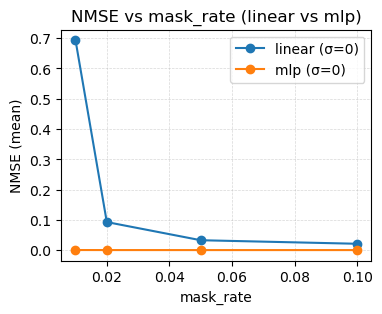

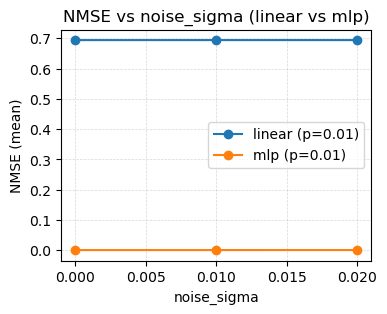

In [1]:
from backend.config.presets import (
    default_data_config,
    default_pod_config,
    default_train_config,
    default_eval_config,
)
from backend.pipeline import run_full_eval_pipeline

data_cfg = default_data_config()
pod_cfg = default_pod_config()
eval_cfg = default_eval_config()
train_cfg = default_train_config(mask_rate=0.02, noise_sigma=0.01)

result = run_full_eval_pipeline(
    data_cfg=data_cfg,
    pod_cfg=pod_cfg,
    eval_cfg=eval_cfg,
    train_cfg=train_cfg,
    verbose=True,
)

df_lin = result["df_linear"]
df_mlp = result["df_mlp"]
fig1 = result["fig_nmse_vs_mask"]
fig2 = result["fig_nmse_vs_noise"]
